In [1]:
import numpy as np
import os
import json
import sys
import matplotlib.pyplot as plt
import skimage

sys.path.append("../")
import src.plot as myplot
import seaborn as sns
from scipy.stats import rankdata
import scipy.stats as stats
import sklearn

In [2]:
import importlib
import src.plot as myplot
importlib.reload(myplot)

<module 'src.plot' from '/Users/paulhosek/PycharmProjects/mcm/MCM_classifier/Classifier_1/mcm/paper_plots/../src/plot.py'>

In [15]:

import importlib
import src.paper_utils as utils
importlib.reload(utils)

<module 'src.paper_utils' from '/Users/paulhosek/PycharmProjects/mcm/MCM_classifier/Classifier_1/mcm/paper_plots/../src/paper_utils.py'>

In [16]:

def same_len_iters_short_long(all_byk_modspin):
    nicc_mods = [len(i) for i in all_byk_modspin] # 33, 30
    mods_long_short_i = np.argsort(nicc_mods)[::-1]

    nicc_mods
    long_iter = np.arange(nicc_mods[mods_long_short_i[0]])
    short_iter = np.append(np.arange(nicc_mods[mods_long_short_i[1]]),[-1 for _ in range(np.abs(np.diff(nicc_mods))[0])])
    return short_iter, long_iter, mods_long_short_i

def predicted_labels_byk_dig(all_byk, all_byk_modspin, mcms_range, dig):
    short_iter, long_iter, mods_long_short_i = same_len_iters_short_long(all_byk_modspin)
    img_dig_i = mcms_range.index(dig)

    out = np.zeros((len(long_iter), 2))
    for k in range(len(long_iter)):

        predicted_labels = np.where(all_byk[mods_long_short_i[0]][long_iter[k],:, img_dig_i] > 
                                all_byk[mods_long_short_i[1]][short_iter[k],:, img_dig_i],
                                mcms_range[mods_long_short_i[0]], mcms_range[mods_long_short_i[1]])

        v, c = np.unique(predicted_labels,return_counts=True)
        for iv, val in enumerate(v):
            out[k, mcms_range.index(val)] = c[iv]
            
    return out

def nestedlist3_to_numpy2d(run_own_label_pred, idx, nrun):
    a = [rolp[:,idx] for rolp in run_own_label_pred]
    b = np.full([len(a),len(max(a,key = lambda x: len(x)))], fill_value=np.nan)
    for i,j in enumerate(a):
        b[i][0:len(j)] = j
    return b

def nestedlist2_to_numpy2d(a):
    b = np.zeros([len(a),len(max(a,key = lambda x: len(x)))])
    for i,j in enumerate(a):
        b[i][0:len(j)] = j
    return b



endpoints = (5,15,121)
def make_3_pmaps(dists, comms, endpoints):
    # note, maintains order of input digits

    def bool_map(dists, comms, dig_idx, endpoint, minus_11x11=0):
        dist_map = dists[dig_idx][comms[dig_idx]]
        ranks = stats.rankdata(dist_map.max()-dist_map, method="dense").reshape(dist_map.shape)
        return (ranks < endpoint).astype(int) - minus_11x11

    pmaps = []
    for dig_i in range(2):
        a = bool_map(dists, comms, dig_i, endpoints[0])
        b = bool_map(dists, comms, dig_i, endpoints[1], a)
        c = bool_map(dists, comms, dig_i, 121, a+b)
        pmaps.append(np.array([a,b,c]))
    return np.array(pmaps)





In [17]:
# # not trash just takes ages to run this
# sample_sizes = [5423]
# counts_samplesizes, mcms_samplesizes = utils.load_counts_mcm(sample_sizes, letter="", path_format="../data/Output/mcm/sample_sizes")
# atest_mcms, atest_probs = utils.get_complete_testprobs(mcms_samplesizes,counts_samplesizes,sample_sizes,n_runs=50,smooth=True)


# np.save(f"./data_for_plots/atest_mcms_{sample_sizes[0]}.npy", atest_mcms)
# np.save(f"./data_for_plots/atest_probs_{sample_sizes[0]}.npy", atest_probs)



In [18]:
def adjust_power1overR(all_byk_pair, all_byk_modspin):
    return [all_byk_pair[i] ** 1/all_byk_modspin[i][:,None,None] for i in range(2)]


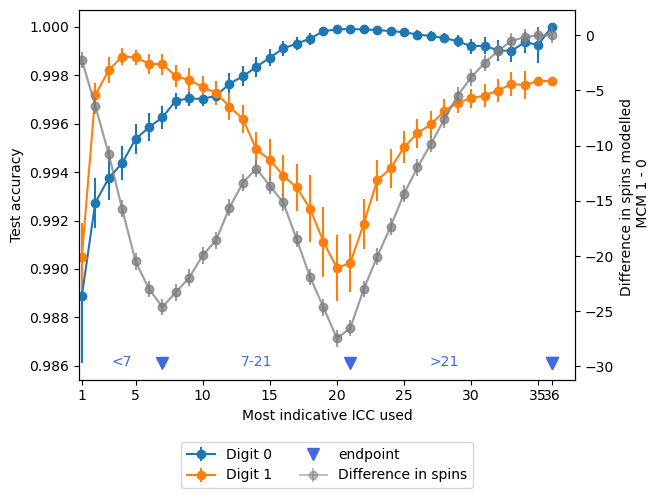

In [80]:
sample_idx = 0
run_idx = 0
mcms_range = [0,1]
sample_sizes = [5423]
atest_mcms = np.load(f"./data_for_plots/atest_mcms_{sample_sizes[0]}.npy")
atest_probs = np.load(f"./data_for_plots/atest_probs_{sample_sizes[0]}.npy")

dist_map_adjust_pixelwise = True
adjust_by_unmodelled = False
adjust_by_pixelwise = True




run_label_pred = []
run_nspin_diff = []

nrun = 50
pmaps = []
for i in range(nrun):
    try:
        # note that even if we adjust the Probs for the distances by 1/r, the raw probs are returned
        all_byk_pair, all_byk_modspin, comms, dists  = utils.get_all_byk_pair(atest_probs, atest_mcms, mcms_range, sample_idx, i,adjust_by_size=dist_map_adjust_pixelwise, return_comms=True, return_dists=True)
        if adjust_by_pixelwise:
            all_byk_pair = adjust_power1overR(all_byk_pair, all_byk_modspin)
        all_byk, nspin_diff, mods_long_short = utils.adjust_smaller_icc(all_byk_pair,all_byk_modspin, dont_adjust=adjust_by_unmodelled)
        label_pred = np.array([predicted_labels_byk_dig(all_byk,all_byk_modspin, mcms_range, dig)[:,mcms_range.index(dig)] for dig in mcms_range]).T/892

        run_label_pred.append(label_pred)
        run_nspin_diff.append(nspin_diff)
        pmaps.append(make_3_pmaps(dists, comms, endpoints))
    except IndexError:
        continue



run_label_pred = np.array([nestedlist3_to_numpy2d(run_label_pred, idx, nrun) for idx in range(2)])



colors = np.array(myplot.get_list_fromcmap("tab10", N=10))

# -----------
fig, ax1 = plt.subplots()
data = run_label_pred
means = np.nanmean(data, axis=1)
sem = stats.sem(data, axis=1, nan_policy='omit')  # Calculate the standard error of the mean
confidence_interval = 1.96 * sem  # 95% confidence interval

maxlen = means.shape[1]

for i in range(2):
    ax1.errorbar(np.arange(1, maxlen+1), means[i], yerr=confidence_interval[i], fmt='-o', label=f"Digit {mcms_range[i]}", color=colors[mcms_range[i]])

# ax1.plot(np.arange(1, maxlen+1), means.mean(axis=0), "k--")

ax1.set_ylabel("Test accuracy")
ax1.set_xlabel("Most indicative ICC used")
ax1.legend(title="Show digit")
# run_nspin_diff

ax2 = ax1.twinx()
run_nspin = nestedlist2_to_numpy2d(run_nspin_diff)
sem_nspin = stats.sem(run_nspin, axis=0, nan_policy='omit')  # Calculate the standard error of the mean

confidence_interval_sem = 1.96 * sem_nspin
ax2.errorbar(np.arange(1, run_nspin.shape[1]+1), np.nanmean(run_nspin, axis=0), yerr=confidence_interval_sem[i], fmt='-o', color="grey", alpha=.5, label="Difference in spins")
ax2.errorbar(np.arange(1, run_nspin.shape[1]+1), np.nanmean(run_nspin, axis=0), yerr=confidence_interval_sem[i], fmt='-o', color="grey", alpha=.5)

# ax2.plot(nspin_diff, color="grey", alpha=.5, label="Difference in spins")
# ax2.axvline(np.min([len(arr) for arr in all_byk_modspin]), color="grey", alpha=.5, linestyle="--", label=f"End of shorter MCM {mcms_range[mods_long_short[1]]}")
ax2.set_ylabel(f"Difference in spins modelled \n MCM {mcms_range[mods_long_short[0]]} - {mcms_range[mods_long_short[1]]}")

# Plotting the endpoint triangles


if np.sum(mcms_range) == 1: # 0vs 1
    endpoints = (7,21,run_nspin.shape[1])
else:   # 3vs 5
    endpoints = (6,14,run_nspin.shape[1])
# Get current y-axis limits for both axes
# y_min_ax1, y_max_ax1 = ax1.get_ylim()
# y_min_ax2, y_max_ax2 = ax2.get_ylim()

# # Calculate the new lower limit by reducing the current lower limit by 10% of the range
# new_y_min_ax1 = y_min_ax1 - (y_max_ax1 - y_min_ax1) * 0.02
# new_y_min_ax2 = y_min_ax2 - (y_max_ax2 - y_min_ax2) * 0.02

# ax1.set_ylim(new_y_min_ax1, y_max_ax1)
# ax2.set_ylim(new_y_min_ax2, y_max_ax2)

# y_min, y_max = new_y_min_ax2, y_max_ax2
y_min, y_max = ax2.get_ylim()  # Get the current limits of the y-axis
x_labels_endpoints = (f"<{endpoints[0]}",f"{endpoints[0]}-{endpoints[1]}",f"{'>'+str(endpoints[1])}")
y_text_offset = (y_max - y_min)  # Calculate a small offset for the text to appear above the marker
r_ep = [1]+list(endpoints)
for xi, x in enumerate(endpoints):
    # ax2.text(x-1.5, y_min*1.01, str(x_labels_endpoints[xi]), color='royalblue', ha='center')
    ax2.text((r_ep[xi+1]+r_ep[xi])//2, y_min*1.01, str(x_labels_endpoints[xi]), color='royalblue', ha='center')

    ax2.plot(x, y_min*1, 'v', color='royalblue', markersize=8)
ax2.plot(x, y_min, 'v', color='royalblue', markersize=8,label="endpoint")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper center",ncol=2, bbox_to_anchor=(0.5, -0.15))
ax1.set_xticks([1]+list(np.arange(0, maxlen,5)[1:])+[maxlen])
ax1.set_xlim(left=.8)




# plt.title(f"""Dists pixelwise={dist_map_adjust_pixelwise},\n between MCM adjusted by: {"1/2 unmoddled spins, " if adjust_by_unmodelled else ""} {"1^1/r" if adjust_by_pixelwise else ""}""")
plt.savefig(f"./img/testacc_icc_{mcms_range[0]}{mcms_range[1]}_nrun{nrun}", bbox_inches="tight", dpi=300)
plt.show()


In [78]:
r_ep
r_ep[1] - r_ep[0]

6

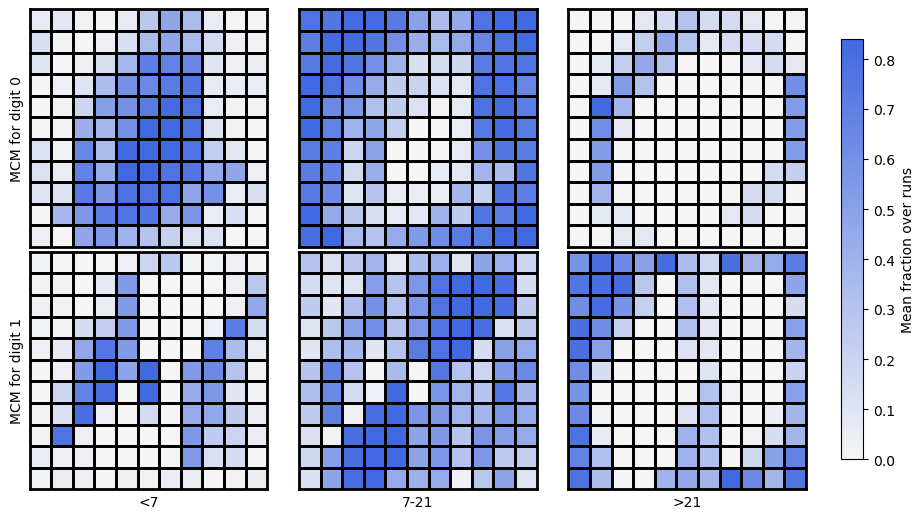

In [69]:
res = np.array(pmaps).mean(axis=0)
cmap = myplot.cmap_to_gray("royalblue", reverse=True)
x_labels = (f"<{endpoints[0]}",f"{endpoints[0]}-{endpoints[1]}",f"{'>'+str(endpoints[1])}")

fig, axs = plt.subplots(2, 3, figsize=(11, 6))

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        ax = axs[i, j]
        out = res[i][j]
        im = myplot.partition_map(ax, out, None, myplot.find_borders(np.arange(121).reshape((11,11))), cbar=False, normalise=False, cmap=cmap)
        if i == 1:
            ax.set_xlabel(f"{x_labels[j]}")
            # ax.text(-0.2, 0.5, f"Digit {i}", transform=ax.transAxes, va='center', ha='right')
        if j == 0:
            ax.set_ylabel(f"MCM for digit {mcms_range[i]}")

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.83,
                    wspace=0.02, hspace=0.02)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])

cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Mean fraction over runs')



plt.savefig(f"./img/testacc_icc_pmaps{mcms_range[0]}{mcms_range[1]}_nrun{nrun}", bbox_inches="tight", dpi=300)


In [9]:
all_byk_pair, all_byk_modspin, comms, dists = utils.get_all_byk_pair(atest_probs, atest_mcms, mcms_range, sample_idx, i,adjust_by_size=True, return_comms=True, return_dists=True)


In [10]:
raise KeyboardInterrupt

KeyboardInterrupt: 

In [ ]:
own_label_pred = np.array([predicted_labels_byk_dig(all_byk,all_byk_modspin, mcms_range, dig)[:,mcms_range.index(dig)] for dig in mcms_range]).T/892

xrange = np.arange(1,len(nspin_diff)+1)
colors = np.array(myplot.get_list_fromcmap("tab10", N=10))

fig, ax1 = plt.subplots()

# Plot own_label_pred on the primary y-axis
for i in range(2):
    ax1.plot(xrange,own_label_pred[:, i], label=f"Digit {mcms_range[i]}", color=colors[mcms_range[i]])


ax1.set_ylabel("Test accuracy")
ax1.set_xlabel("Most indicative ICC used")
ax1.legend(title="Show digit")
# ax1.set_title(f"Test accuracy on own digit over k for {mcms_range} \n Using NB classifier of the 2 MCMs only.")

ax2 = ax1.twinx()
ax2.plot(xrange,nspin_diff, color="grey", alpha=.5, label="Difference in spins")
ax2.axvline(np.min([len(arr) for arr in all_byk_modspin]), color="grey", alpha=.5, linestyle="--", label=f"End of shorter MCM {mcms_range[mods_long_short[1]]}")
ax2.set_ylabel(f"Difference in spins modelled \n MCM {mcms_range[mods_long_short[0]]} - {mcms_range[mods_long_short[1]]}")

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper center",ncol=2, bbox_to_anchor=(0.5, -0.15))
ax1.set_xticks([1]+list(np.arange(0, xrange.max(),5)[1:])+[xrange.max()])
ax1.set_xlim(left=.8)
plt.savefig(f"./img/testacc_icc_{mcms_range[0]}{mcms_range[1]}", bbox_inches="tight", dpi=300)
# plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

### The partition maps that made this 
- largly copied from plots_indicative_icc

In [ ]:
# copied from plots_indicative_icc and changed some details

run_i = 0
samples_path = "../data/OUTPUT/mcm/sample_sizes"
mcms_fname = f"MCMs_{run_i}.json"# 0 is run index
counts_fname = f"Counts_{run_i}.json"
n_samples = sample_sizes[0]

with open(os.path.join(samples_path,str(n_samples),"MCMs", mcms_fname), "r") as f:
        all_MCM = [np.array(i) for i in json.load(f)] 


with open(os.path.join(samples_path,str(n_samples),"Counts", counts_fname), "r") as f:
        C = json.load(f)


cat_a = mcms_range[1]
cat_b = mcms_range[0]
mcm_index = mcms_range[1]
n_variables = 121
test_data_path = "../data/INPUT_all/data/testdata_separated"
test_data_filename_format = "test-images-unlabeled-{}.dat"
test_all_C_icc = myplot.calculate_P_icc(C, all_MCM,mcm_index,n_variables, test_data_path,test_data_filename_format)

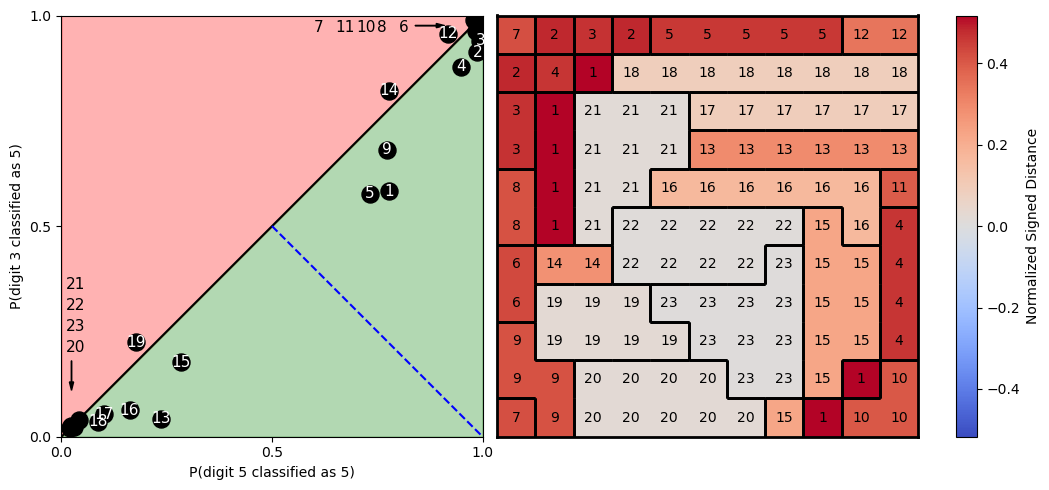

In [ ]:
mode = "rank" # or letter
scat_size = 130 if mode != "rank" else 150

all_prob = test_all_C_icc/n_samples # for MCM 0
avg_prob = all_prob.mean(axis=1)

comms = myplot.generate_icc_comms_map(all_MCM[mcm_index])
distances = utils.normalised_signed_distance_decisionbound(avg_prob, cat_a, cat_b)
dist_map = distances[comms]
ranks = rankdata(dist_map.max()-dist_map, method="dense").reshape(dist_map.shape)
letters = myplot.int_to_letters(comms)

#-----------
scale = 1
fig, axs  = plt.subplots(1,2,figsize=(12*scale,5*scale))
axs = axs.flatten()
axs[0].set_aspect('equal')
axs[0].set_xticks([0, 0.5, 1])
axs[0].set_yticks([0, 0.5, 1])
# axs[0].grid(True, linestyle='--', alpha=0.6)

# decision space
axs[0].plot([0, 1], [0, 1], color='black')
axs[0].fill_between([0, 1], [0, 1], 1, where=[True, True], color='red', alpha=0.3)
axs[0].fill_between([0, 1], [0, 1], 0, where=[True, True], color='green', alpha=0.3)
axs[0].plot([0.5, 1], [0.5, 0], color='blue', linestyle='--')


axs[0].scatter(avg_prob[:, cat_a], avg_prob[:, cat_b], color="black", marker="o", label=cat_b,s=scat_size)
# Labeling of scatter plot
left_side_y = .2  # for the bottom left corner
right_side_x = 1-0.2 # for the top right corner
any_bottomright = False
any_topleft = False
for i, (x, y) in enumerate(zip(avg_prob[:, cat_a], avg_prob[:, cat_b])):
    lab = myplot.int_to_letters(i)
    if mode == "rank":
        lab = ranks[letters == myplot.int_to_letters(i)][0]
    if x < 0.05 and y < 0.05:
        axs[0].text(0.01, left_side_y, lab, color="black", transform=axs[0].transAxes, fontsize=11)
        left_side_y += 0.05
        any_bottomright = True
    elif x > 0.95 and y > 0.95:
        axs[0].text(right_side_x, 0.96, lab, color="black", transform=axs[0].transAxes, fontsize=11)
        right_side_x -= 0.05
        any_topleft = True
    else:
        axs[0].text(x, y, lab, color="white", ha="center", va="center", fontsize=11)

if any_bottomright:
    axs[0].arrow(0.024, 0.18, 0, -0.05, head_width=0.01, head_length=0.02, fc='black', ec='black')
if any_topleft:
    axs[0].arrow(1-0.16, 1-0.024, 0.05, 0, head_width=0.01, head_length=0.02, fc='black', ec='black')




# other stuff
axs[0].set_xlabel(f"P(digit {cat_a} classified as {cat_a})")
axs[0].set_ylabel(f"P(digit {cat_b} classified as {cat_a})")
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1)
plt.subplots_adjust(wspace=-.7)
axs[1].set_aspect('equal')


if mode == "rank":
    im = myplot.partition_map(plt.gca(), dist_map,ranks,myplot.find_borders(comms), cbar=False)
else:
    im = myplot.partition_map(plt.gca(), dist_map,myplot.int_to_letters(comms),myplot.find_borders(comms), cbar=False)


plt.colorbar(im, ax=axs[1]).set_label('Normalized Signed Distance')
plt.tight_layout()  
plt.savefig(f"./img/decisionboundary_and_map_{cat_a}{cat_b}_matchbyk.png", dpi=300, bbox_inches="tight")
plt.show()



### Confusion matrix for some k

In [ ]:
# test_probs[0,0,:,0]
# full_mcm_idx = [np.where(test_probs[mcm_i,0,:,0] == -1,)[0][0]-1 for mcm_i in range(10)]
# test_probs.shape

In [ ]:
per_image_prob = np.product(test_probs,axis=2,where=test_probs!=-1) # this correct be cause get_complete_testprobs gives the probability for each icc

In [ ]:
# digitwise accuracy
max_decision_unit = np.argmax(per_image_prob,axis=0) # out of the 10 mcm seeing the same digit, which one was the most probable
digit_accu = [1-np.count_nonzero(max_decision_unit[k,:] - k)/892 for k in range(10)]
digit_accu
# np.mean(digit_accu)

[0.9730941704035875,
 0.9775784753363229,
 0.9495515695067265,
 0.929372197309417,
 0.9226457399103138,
 0.9204035874439462,
 0.945067264573991,
 0.9047085201793722,
 0.8878923766816144,
 0.8957399103139013]

In [ ]:
# for every set of testimages, compute 

# the most likely label the NB classifier gave to each image (10, 892)
predicted_labels_per_image = np.argmax(per_image_prob,axis=0)

v, c = np.unique(predicted_labels_per_image, return_counts=True,axis=1)
# list of tuples: each tuple is each wrong label:count how often each label
unqs = [np.unique(arr, return_counts=True) for arr in predicted_labels_per_image]

idx_arr = np.zeros((10,10))
for i in range(10):
    idx_arr[i][unqs[i][0]] = unqs[i][1]

idx_arr /= 982


np.fill_diagonal(idx_arr, 0)
# np.fill_diagonal(idx_arr,idx_arr.max())
idx_arr


# unqs[i][0]

array([[0.        , 0.        , 0.00305499, 0.00101833, 0.        ,
        0.00509165, 0.00305499, 0.00203666, 0.00916497, 0.00101833],
       [0.        , 0.        , 0.00610998, 0.00101833, 0.00101833,
        0.        , 0.00305499, 0.00101833, 0.00814664, 0.        ],
       [0.00407332, 0.00203666, 0.        , 0.0101833 , 0.00610998,
        0.00101833, 0.00305499, 0.00814664, 0.0101833 , 0.00101833],
       [0.00101833, 0.        , 0.01527495, 0.        , 0.00101833,
        0.0305499 , 0.        , 0.00610998, 0.00916497, 0.00101833],
       [0.        , 0.00101833, 0.00407332, 0.00101833, 0.        ,
        0.00101833, 0.00814664, 0.00407332, 0.00916497, 0.04175153],
       [0.00814664, 0.00203666, 0.        , 0.02647658, 0.        ,
        0.        , 0.00814664, 0.        , 0.02240326, 0.00509165],
       [0.01120163, 0.00407332, 0.00407332, 0.00203666, 0.00407332,
        0.01221996, 0.        , 0.00101833, 0.01120163, 0.        ],
       [0.00101833, 0.00712831, 0.0193482

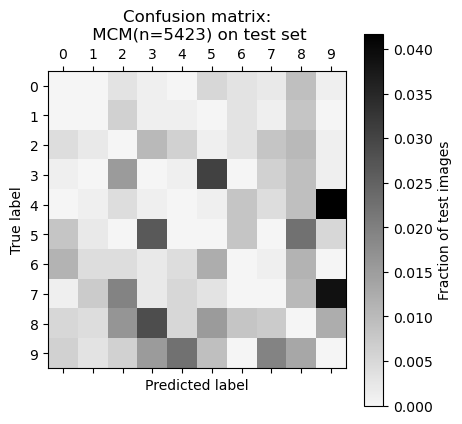

In [ ]:
im = myplot.plot_confusion_matrix(idx_arr,10,logScale=False,cmap=myplot.cmap_to_gray("black",reverse=True),title="Confusion matrix:\n MCM(n=5423) on test set")
plt.colorbar(im,).set_label("Fraction of test images")